## Create dummy data and labels

This notebook is to show the functions of 'dummy_data_functions.py'. It can:
+ Add sines of different frequencies to create a signal.
+ Create and plot a distribution of frequencies within a range.
+ Get random frequencies from these frequency distributions.
+ Create random signals from any frequency distribution.
+ Organise data into subjects, epochs, and channels, along with a label.

Dummy data is useful for:
+ Reproducability of the results.
+ Running notebooks if no real EEG data is available
+ Providing a method of organising EEG data so it can act as input for classification models.
+ Checking whether classification models work by training on easily discernable dummy signals.
+ Comparing the learning speed and pattern recognition capabilities between different models.

#### Imports

In [1]:
import numpy as np   
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
import os              
import sys

main_path = os.path.dirname(os.getcwd())
eegyolk_path = os.path.join(main_path, 'eegyolk')
sys.path.insert(0, eegyolk_path)
from eegyolk import dummy_data_functions as dummy
from eegyolk import display_helper as disp


#### Data Variables:

In [2]:
duration = 2                                # Total duration signal (seconds)
sample_rate = 512                           # Data points per second (Hertz)
N_time_points = sample_rate * duration      # Total number of data points
time_points = np.linspace(0, duration, N_time_points, endpoint=False)

N_combined_freq = 100                       # Number of frequencies to form signal
max_freq = 200                              # Maximum frequency of signal
freq_sample_rate = 10                       # Resolution of frequency
N_freq_points = max_freq * freq_sample_rate

frequencies = np.linspace(0, max_freq, N_freq_points, endpoint=False)
freq_distribution = dummy.generate_frequency_distribution(
    "planck", max_freq, freq_sample_rate)

#### Create a Dummy signal

+ Add sines of different frequencies to create a signal.

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

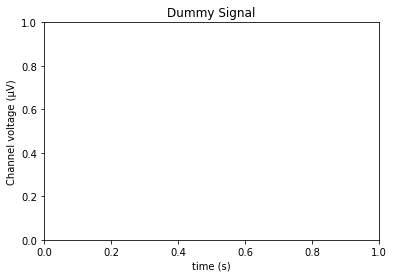

In [3]:
signal = dummy.generate_sine_wave(5, time_points)
noise = dummy.generate_sine_wave(60, time_points) * 0.2
noise += dummy.generate_sine_wave(600, time_points) * 0.1

wave = signal + noise
disp.show_plot(time_points, wave, "Dummy Signal", "time (s)", "Channel voltage (\u03BCV)")

The above cell breaks because of line 22 in your function. You are trying to do logical operations on numpy arrays. This gives you something undefined. Also, your defaults are booleans , and your expected values are numpy arrays. 
I might just plot with plain old matplotlib.
If you WANT TO USEthis function, it need to be recoded.
Below is how I would rewrite the function. I'll put it in eggyolk as plotter_show

In [4]:
def plotter_show(x=None, y=None, title="", xlabel="", ylabel="", legend="", show=True):
    '''
     Show plot with title and lables in 1 line.

    Args:
     x: 1D numpy array        

     y: 1D numpy array

    '''
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if legend:
        plt.legend(legend)
    if (x is not None) and (y is not None):
        plt.plot(x, y)
    if show:
        plt.show()

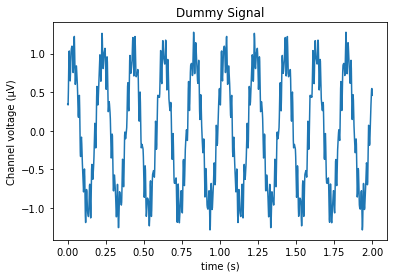

In [6]:
plotter_show(time_points, wave, "Dummy Signal", "time (s)", "Channel voltage (\u03BCV)")

#### Frequency Probability Distribution 
+ Create and plot a distribution of frequencies within the range of 0-200 Hz. 
+ The frequency distribution below is roughly similar to the Fourier Transform of real EEG data.

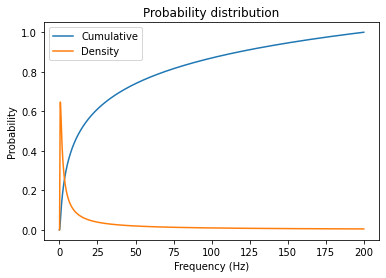

In [7]:
cumulative = np.cumsum(freq_distribution)
cumulative /= cumulative[-1] # Normalise

disp.show_plot(None, None, "Probability distribution", "Frequency (Hz)", "Probability", show = False)
plt.plot(frequencies, cumulative, label = "Cumulative")
plt.plot(frequencies, freq_distribution/cumulative[-1], label = "Density")
plt.legend()
plt.show()    

#### Get Random Frequencies from Density Distribution 
+ Frequencies are randomly drawn from the frequency distribution. These frequencies are used to make a signal.

In [8]:
print("Random Frequencies from Distribution:")
for i in range(5):
    print(f'{dummy.random_frequency_from_density_distribution(max_freq, freq_distribution):.3f}')

Random Frequencies from Distribution:
1.200
8.900
65.300
173.400
5.000


#### Create Signals from these Random Frequencies
+ Signals can be generated from any frequency distribution.

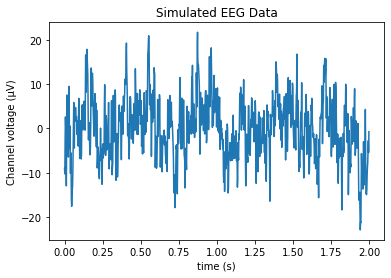

In [11]:
epoch = dummy.generate_epoch(freq_distribution, N_combined_freq, max_freq, duration, sample_rate)
plotter_show(time_points, epoch, "Simulated EEG Data", "time (s)", "Channel voltage (\u03BCV)")

#### Fourier Transform of Dummy Signal

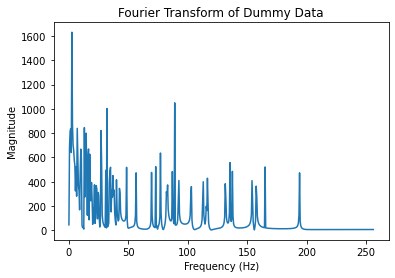

In [13]:
epoch_FT = rfft(epoch)
freq = rfftfreq(duration * sample_rate, 1 / sample_rate)
plotter_show(freq, np.abs(epoch_FT), "Fourier Transform of Dummy Data", "Frequency (Hz)", "Magnitude")

#### Generating Data
+ Put signals into array with dimensions (subjects, channels, epochs) 
+ Subjects in group 1 have a 'planck's law' frequency distribution
+ Subjects in group 2 have a linear frequency distribution


In [14]:
subjects_1 = []
N_subjects_1 = 5
planck_distribution = dummy.generate_frequency_distribution("planck", max_freq, freq_sample_rate)

subjects_2 = []
N_subjects_2 = 5
lin_distribution = dummy.generate_frequency_distribution("linear", max_freq, freq_sample_rate)

N_epochs = 5
N_channels = 8

for i in range(N_subjects_1):
    epochs = []
    for k in range(N_epochs):
        channels = []
        for j in range(N_channels):
            channels.append(dummy.generate_epoch(planck_distribution, N_combined_freq, max_freq, duration, sample_rate))
        epochs.append(channels)
    subjects_1.append(epochs)

for i in range(N_subjects_2):
    epochs = []
    for k in range(N_epochs):
        channels = []
        for j in range(N_channels):
            channels.append(dummy.generate_epoch(lin_distribution, N_combined_freq, max_freq, duration, sample_rate))
        epochs.append(channels)
    subjects_2.append(epochs)


Create Labels

In [15]:
subjects = np.concatenate([subjects_1,subjects_2])
labels = np.concatenate([np.ones(len(subjects_1)),np.zeros(len(subjects_2))])

print(labels)

[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]


#### Plot Generated Data


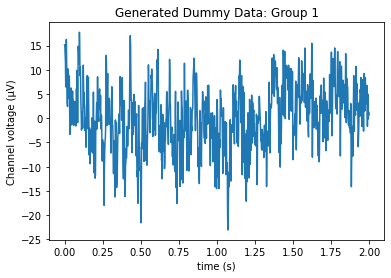

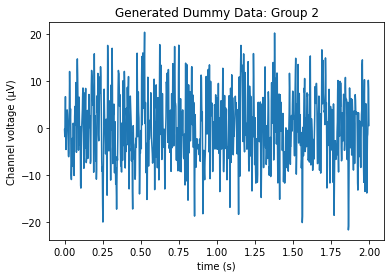

In [17]:
subject_index = 2
channel_index = 7
epoch_index = 1

time_points = np.linspace(0, duration, N_time_points, endpoint=False)
plotter_show(time_points, subjects_1[subject_index][epoch_index][channel_index], "Generated Dummy Data: Group 1", "time (s)", "Channel voltage (\u03BCV)")
plotter_show(time_points, subjects_2[subject_index][epoch_index][channel_index], "Generated Dummy Data: Group 2", "time (s)", "Channel voltage (\u03BCV)")

#### Fourier transform of the above signal

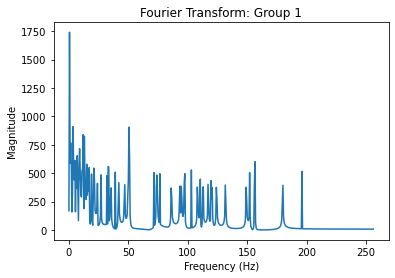

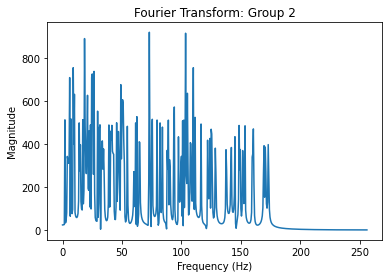

In [20]:
epoch_FT = rfft(subjects_1[subject_index][epoch_index][channel_index])
freq = rfftfreq(duration * sample_rate, 1 / sample_rate)
plotter_show(freq, np.abs(epoch_FT), "Fourier Transform: Group 1", "Frequency (Hz)", "Magnitude")

epoch_FT = rfft(subjects_2[subject_index][epoch_index][channel_index])
freq = rfftfreq(duration * sample_rate, 1 / sample_rate)
plotter_show(freq, np.abs(epoch_FT), "Fourier Transform: Group 2", "Frequency (Hz)", "Magnitude")